In [1]:
# -*- coding:utf-8 -*-
import geopandas
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
# conda install -c conda-forge spaghetti (if using conda)
import spaghetti
import os
import glob
import smopy
from haversine import haversine, Unit

import pandas as pd
import networkx as nx
import osmnx
from matplotlib import pyplot as plt

import collections
import numpy as np
import math

import esda
import warnings

warnings.filterwarnings("ignore")

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_2816/2613326214.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas
/Users/nat_rng/opt/anaconda3/envs/nda_env/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` ge

In [2]:
# define the place which we need to research
PLACE_OF_INTEREST = "Leeds City Centre, Leeds, United Kingdom"
# get the gdf by using osmnx.geocode_to_gdf() and set the distance of buffer at 1000 meters.
leeds_center = osmnx.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=1000)

# From this take the polygon that defines Leeds's boundary
leeds_polygon = leeds_center['geometry'][0]
# we can see that the buffer is like an oval
leeds_polygon

print("The coordinates of the area chosen is (Lat:{},Lon:{}).".format(leeds_center.lat.values,leeds_center.lon.values))

The coordinates of the area chosen is (Lat:[53.8091284],Lon:[-1.53023679]).


In [3]:
USE_COLS = ['Grid Ref: Easting', 'Grid Ref: Northing']
# choose the data in nearly five years.
year_list = ["2017","2018","2019"]
# creat a list to store the data
leeds = []
for i in range(len(year_list)):
    leeds_df = pd.read_csv("data/" +'Leeds_RTC_'+ year_list[i] +'.csv',encoding='ISO-8859-1')
    leeds.append(leeds_df)
# drop the column named "Channel" and "Region"
# merge the five years data into one dataframe.
leeds_df = pd.concat([x for x in leeds],axis=0,ignore_index=True)
leeds_df = leeds_df.dropna(subset=USE_COLS)

In [4]:
gdf = geopandas.GeoDataFrame(
    leeds_df, geometry=geopandas.points_from_xy(leeds_df["Grid Ref: Easting"], leeds_df["Grid Ref: Northing"],crs="EPSG:27700"))
gdf_new=gdf.to_crs(epsg=4326).drop(['Grid Ref: Northing','Grid Ref: Easting'],axis=1)

In [5]:
# get the accident points with their position.
accident_points = gdf_new.geometry
# Now, choosing the accident points which are inside the chosen area.
leeds_accident = gdf_new[accident_points.within(leeds_polygon)]
len(leeds_accident)
# we could find that there are 727 accidents in the chosen area, which is larger than 300.

379

In [6]:
# get the network of streets in Leeds city centre
leeds_graph = osmnx.graph_from_polygon(leeds_polygon,network_type = 'drive')
print(nx.check_planarity(leeds_graph))

# The function is cited by the codes from https://github.kcl.ac.uk/k2143309/7CUSMNDA/blob/master/notebooks/week_2b.ipynb 
def print_graph_statistics(graph):
    print("Number of nodes: {}\nNumber of edges: {}".format(
        graph.number_of_nodes(), graph.number_of_edges()
    ))
    
print_graph_statistics(leeds_graph)

leeds_area = osmnx.project_gdf(leeds_center).unary_union.area
osmnx.basic_stats(leeds_graph, area=leeds_area)
# the number of the junctions is 714

# Some edges (roads in Leeds Center) are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = nx.get_node_attributes(leeds_graph, 'x')
y_values = nx.get_node_attributes(leeds_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(leeds_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

graph_with_geometries[0:4]

# 1657 streets
len(graph_with_geometries)

(True, <networkx.algorithms.planarity.PlanarEmbedding object at 0x14ec05120>)
Number of nodes: 715
Number of edges: 1652


1652

In [7]:
osmnx.plot_graph_folium(leeds_graph)

In [8]:
leeds_area = osmnx.project_gdf(leeds_center).unary_union.area
osmnx.basic_stats(leeds_graph, area=leeds_area)

{'n': 715,
 'm': 1652,
 'k_avg': 4.620979020979021,
 'edge_length_total': 109170.77000000003,
 'edge_length_avg': 66.08400121065377,
 'streets_per_node_avg': 2.6895104895104893,
 'streets_per_node_counts': {0: 0, 1: 152, 2: 14, 3: 456, 4: 90, 5: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2125874125874126,
  2: 0.019580419580419582,
  3: 0.6377622377622377,
  4: 0.1258741258741259,
  5: 0.004195804195804196},
 'intersection_count': 563,
 'street_length_total': 61383.27299999998,
 'street_segment_count': 926,
 'street_length_avg': 66.28863174946002,
 'circuity_avg': 1.0282180128376803,
 'self_loop_proportion': 0.0,
 'node_density_km': 213.51895514844566,
 'intersection_density_km': 168.1275129350698,
 'edge_density_km': 32601.438801610184,
 'street_density_km': 18330.758481890614}

In [9]:
#get shortest paths between all points on the graph
shortest_paths = []
for node in leeds_graph.nodes:
    node_path_lengths = nx.single_source_dijkstra_path_length(leeds_graph, node, weight='length')
    max_path_length = max(node_path_lengths.values())
    shortest_paths.append(max_path_length)

spatial_diameter = max(shortest_paths)
spatial_diameter

3804.313

In [10]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe

,osmid,oneway,lanes,ref,name,highway,maxspeed,reversed,length,geometry,bridge,junction,access
0,491178802,True,2,A61,Regent Street,trunk,30 mph,False,75.411,"LINESTRING (-1.53312 53.80234, -1.53294 53.80301)",NaN,NaN,NaN
1,53014871,True,NaN,NaN,Byron Street,unclassified,20 mph,False,78.630,"LINESTRING (-1.53312 53.80234, -1.53321 53.802...",NaN,NaN,NaN
2,23120678,False,NaN,NaN,Skinner Lane,tertiary,30 mph,True,11.470,"LINESTRING (-1.53260 53.80366, -1.53276 53.80369)",NaN,NaN,NaN
3,38422455,True,2,A61,Regent Street,trunk,NaN,False,67.194,"LINESTRING (-1.53260 53.80366, -1.53276 53.80306)",NaN,NaN,NaN
4,"[169591262, 440408598, 169591263]",False,2,NaN,Skinner Lane,tertiary,30 mph,False,208.128,"LINESTRING (-1.53260 53.80366, -1.53252 53.803...",yes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,1133776017,True,NaN,NaN,Lascelles Road East,residential,NaN,False,10.172,"LINESTRING (-1.51745 53.81399, -1.51741 53.813...",NaN,NaN,NaN
1648,1140215738,False,NaN,NaN,Chapman Street,unclassified,20 mph,True,4.829,"LINESTRING (-1.52390 53.80491, -1.52397 53.80490)",NaN,NaN,NaN
1649,23137264,False,2,NaN,Cherry Row,tertiary,30 mph,False,4.397,"LINESTRING (-1.52867 53.80403, -1.52866 53.80407)",NaN,NaN,NaN
1650,23091062,False,2,NaN,Cherry Row,tertiary,30 mph,True,104.003,"LINESTRING (-1.52867 53.80403, -1.52876 53.803...",NaN,NaN,NaN


<Axes: >

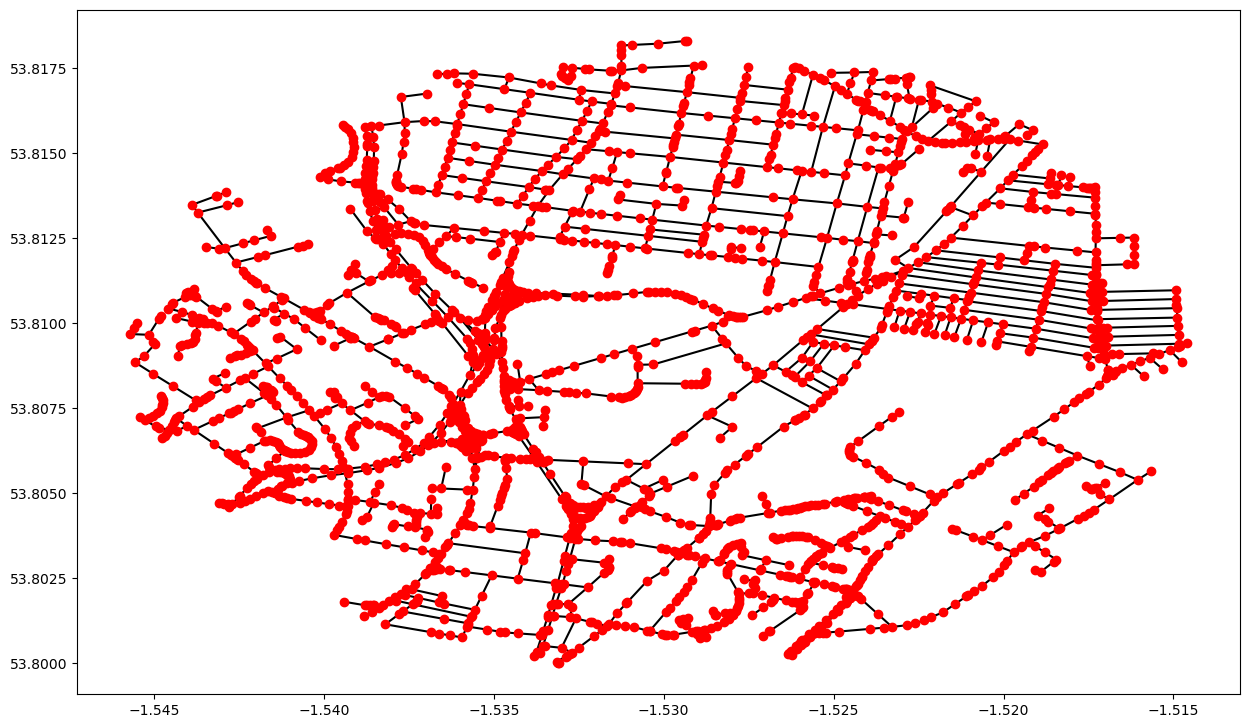

In [11]:
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_points_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

In [12]:
# We will now snap the leeds located accidents we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(leeds_accident, 'accidents')

# We can see the difference between the original crime coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

observation 1
true coords:	(-1.536767709084443, 53.806482451535494)
snapped coords:	(-1.5367669578669456, 53.80647715462963)


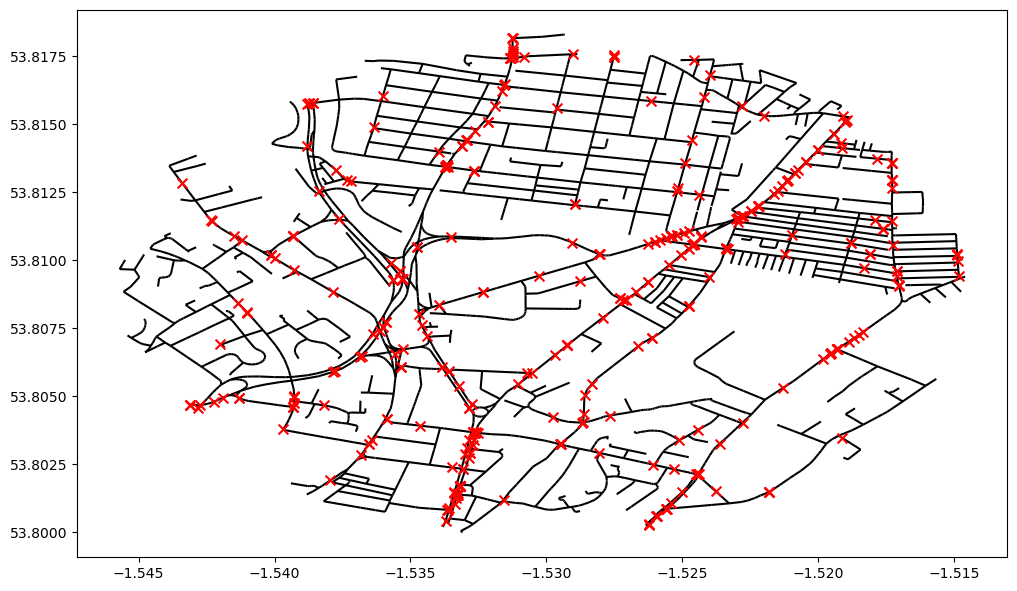

In [13]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

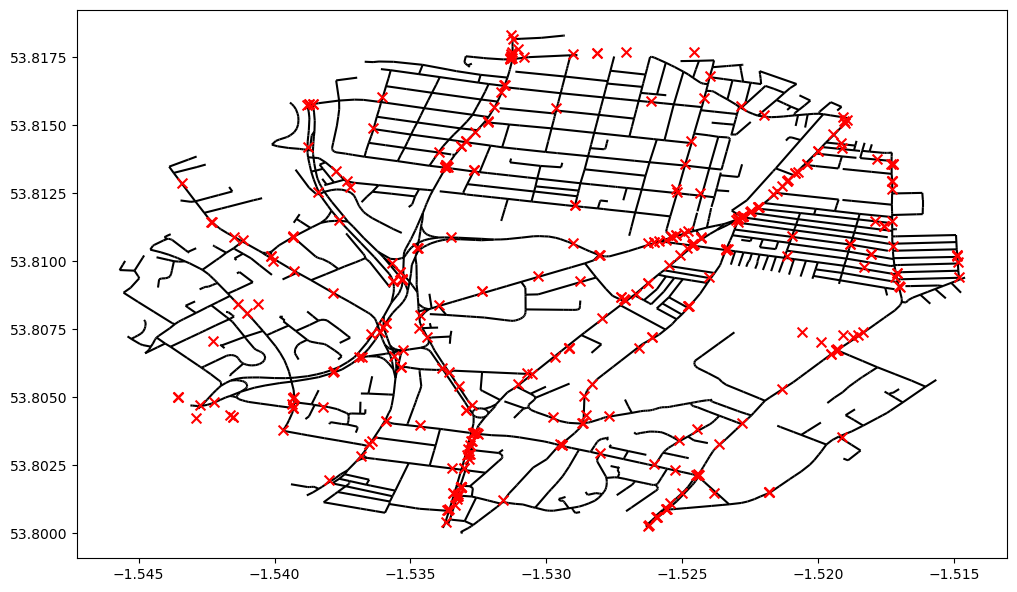

In [14]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the non-snapped (real) crime locations to plot on the net
observed_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=False)

# Plot these on the road network
observed_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.savefig('accidents-observations')

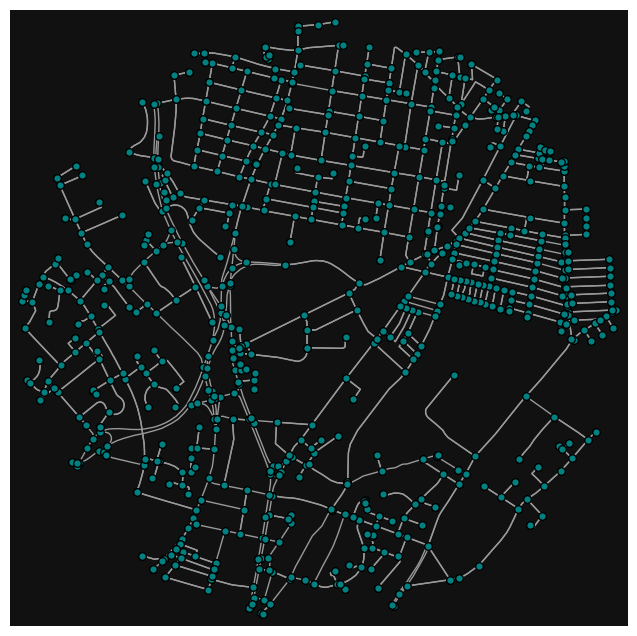

In [15]:
fig = osmnx.plot_graph(leeds_graph, node_color='teal', node_size=30,
node_zorder=2, node_edgecolor='k')

In [16]:
kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["accidents"],
    nsteps=100, permutations=100
)

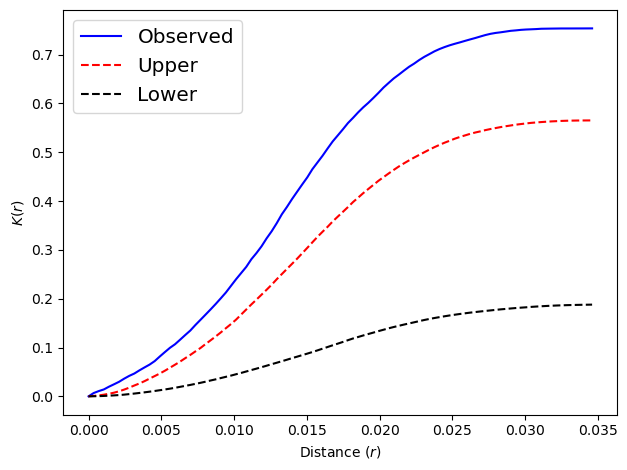

In [17]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

In [18]:
# Get snapped point pattern 
pointpat = leeds_points_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)

In [19]:
pp_name='accidents'
# leeds_points_graph
moran_ntwwn, yaxis_ntwwn = leeds_points_graph.Moran(pp_name,graph=True)
moran_ntwwn.I

0.12061692593103819

In [20]:
moran_ntwwn, yaxis_ntwwn = leeds_points_graph.Moran(pp_name)
moran_ntwwn.I

0.14857507925599178

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.15', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.15)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

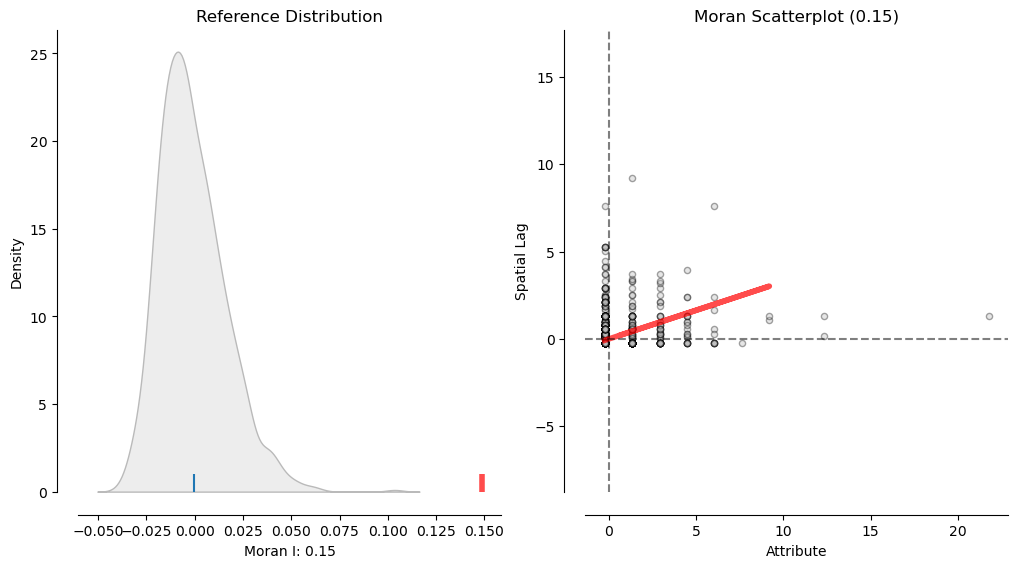

In [21]:
from splot.esda import moran_scatterplot, lisa_cluster, plot_moran
figsize = (12,6)
fitline_kwds = {"color":"r", "lw": 4, "alpha":.7}
scatter_kwds = {"s":20, "edgecolors":"k", "alpha":.35}
pltkwds = {"fitline_kwds": fitline_kwds, "scatter_kwds": scatter_kwds}
plot_moran(moran_ntwwn, zstandard=True, figsize=figsize, **pltkwds)
# almost all the points are gathering in the High-high quadrant.That is, the closer the street is, the easier it is for accidents to gather.

In [22]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_points_graph.w_network

In [23]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

In [24]:
X = snapped_accidents.geometry.x
Y = snapped_accidents.geometry.y
# get which street is the closest to each accident point.
Dist_PtoS = osmnx.nearest_edges(leeds_graph, X, Y, interpolate=None, return_dist=False)

In [25]:
len(Dist_PtoS)

379

In [26]:
fraction = []
for i in range(len(Dist_PtoS)):
    node_start = Dist_PtoS[i][0]
    node_end = Dist_PtoS[i][1]
    # p1 is the accident point
    p1 = (Y[i],X[i])
    # p2 are the start and the end of the street where p1 was happened .
    p2_start = (leeds_graph.nodes()[node_start]['y'],leeds_graph.nodes()[node_start]['x'])
    p2_end = (leeds_graph.nodes()[node_end]['y'],leeds_graph.nodes()[node_end]['x'])
    street_length = haversine(p2_end,p2_start,unit='km')
    dist_start = haversine(p1,p2_start,unit='km')
    dist_end = haversine(p1,p2_end,unit='km')
    if dist_start>=dist_end:
        frac = dist_end/street_length
        fraction.append(frac)
    else:
        frac = dist_start/street_length
        fraction.append(frac)

<Axes: >

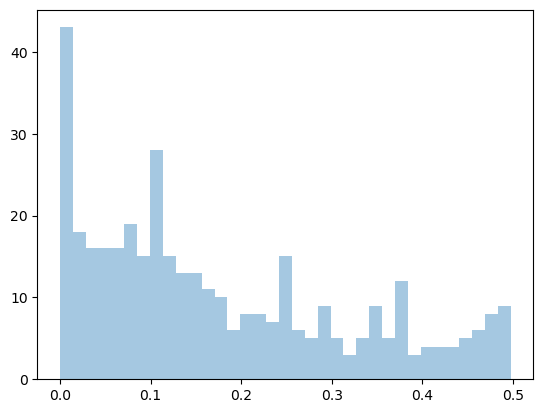

In [27]:
import seaborn as sns
sns.distplot(fraction, bins=35, kde=False)

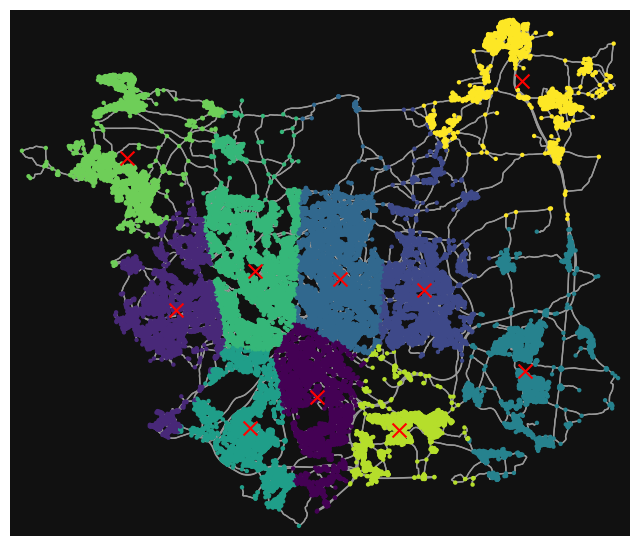

In [28]:
PLACE_OF_INTEREST = "Leeds, UK"
leeds_city_graph = osmnx.graph_from_place(PLACE_OF_INTEREST,network_type = 'drive')

from sklearn.cluster import KMeans

NUMBER_OF_SEEDS = 10

all_nodes = list(leeds_city_graph.nodes(data=True))

# Apply k-means++ algorithm with k = NUMBER_OF_SEEDS to the nodes in the graph using the latitude and longitude as the features
kmeans = KMeans(init = 'k-means++', n_clusters=NUMBER_OF_SEEDS, n_init = "auto", random_state=42).fit([[node[1]['x'], node[1]['y']] for node in all_nodes])

# Get the cluster labels for each node
cluster_labels = kmeans.labels_

# Get the cluster centroids
cluster_centroids = kmeans.cluster_centers_

# Plot the graph with the nodes coloured by cluster label, and the cluster centroids as red crosses
fig, ax = osmnx.plot_graph(leeds_city_graph, node_color=cluster_labels, node_size=10, node_zorder=2, show=False, close=False)
ax.scatter(cluster_centroids[:,0], cluster_centroids[:,1], c='r', marker='x', s=100, zorder=3)
plt.show()

In [29]:
seeds = [osmnx.distance.nearest_nodes(leeds_city_graph, *centroid) for centroid in cluster_centroids]
print(cluster_centroids)
seeds

[[-1.54282862 53.76593795]
 [-1.65510924 53.80678731]
 [-1.45774306 53.81619964]
 [-1.52513308 53.82149739]
 [-1.37776633 53.77819558]
 [-1.59629679 53.75148662]
 [-1.59191329 53.82502075]
 [-1.69344286 53.8782089 ]
 [-1.47803598 53.75068581]
 [-1.38031242 53.91411188]]


[395305638,
 317598135,
 6481110432,
 248497502,
 1955838372,
 380917738,
 1690928998,
 1580869371,
 305698610,
 1560077]

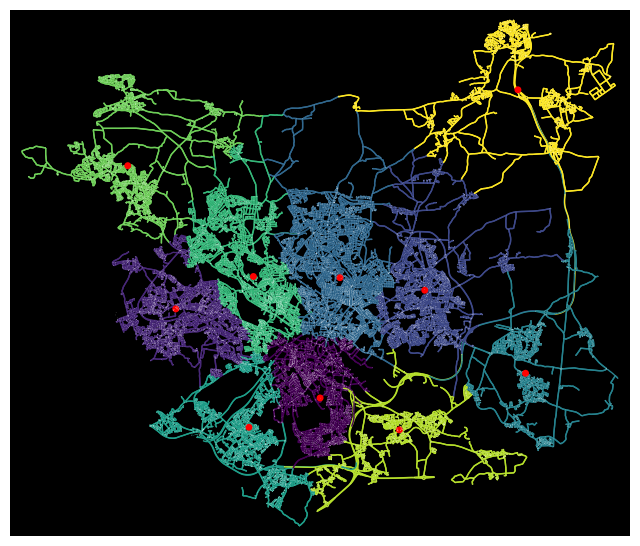

In [30]:
distances = {seed: nx.single_source_dijkstra_path_length(
    leeds_city_graph, seed, weight='length') for seed in seeds}

def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] \
        if len(node_distances) > 0 else None

def nearest_seed(node):
    seed_distances = [(seed, distances[seed][node]) \
        for seed in seeds if node in distances[seed]]
    return nearest_from_list(seed_distances)

def nearest_for_edge(edge):
    nearest_to_ends_all = [nearest_seed(edge[0]), nearest_seed(edge[1])]
    nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
    return nearest_from_list(nearest_to_ends)

colours = osmnx.plot.get_colors(NUMBER_OF_SEEDS)

def colour_for_seed_distance(seed):
    return colours[seeds.index(seed[0])]

edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_city_graph.edges]
# Note that edges not connected to a seed shown in black, so invisible on black background
edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
# edge_colours = np.array(edge_colours, dtype=object)
# For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
all_nodes = list(leeds_city_graph.nodes())
node_colours = ['r' if node in seeds else 'w' for node in all_nodes]
node_size = [25 if node in seeds else 0.1 for node in all_nodes]

# Plot the Voronoi diagram with 10 seed points and 10 cells (one for each seed point)
osmnx.plot.plot_graph(leeds_city_graph, edge_color = edge_colours, node_size = node_size, bgcolor = 'k', node_color = node_colours)
plt.show()

In [31]:
#dict to encode the colours
colour_dict = {colour: i for i, colour in enumerate(set(edge_colours))}
colour_dict
for i, (u,v,k) in enumerate(leeds_city_graph.edges):
    leeds_city_graph.edges[u,v,k]['color_code'] = colour_dict[edge_colours[i]]
# edge_colours

In [32]:
leeds_city_graph.get_edge_data(154962, 3504720, 0)

sub_graphs = []
for i in range(NUMBER_OF_SEEDS):
    sub_graph_edges = []
    for u,v,k in leeds_city_graph.edges:
        if leeds_city_graph.edges[u,v,k]['color_code'] == i:
            sub_graph_edges.append((u,v,k))
    subgraph = leeds_city_graph.edge_subgraph(sub_graph_edges)
    sub_graphs.append(subgraph)


In [33]:
seed_graphs = sub_graphs
# from networkx.algorithms import euler

# def find_eulerian_cycle(seed_graphs):
#     paths = dict()
#     labels = dict()
#     for i,g in enumerate(seed_graphs):
#         if euler.is_eulerian(g):
#             cycle = list(euler.eulerian_circuit(g, keys=True))
#             graph_labels = {(u,v):step for step, (u, v, k) in enumerate(cycle)}
#             paths[i] = cycle
#             labels[i] = graph_labels
#     return paths, labels

# euler_cycle, labels = find_eulerian_cycle(seed_graphs)
# # label_8 = labels[8]
# # print(label_8)

# cycle_lengths = {key: sum([leeds_city_graph.get_edge_data(u, v)[0]['length'] for u,v,_ in cycle]) for key, cycle in euler_cycle.items()}
# cycle_lengths


In [92]:
# # distances_subgraph0 = {node: nx.all_pairs_dijkstra_path_length(
# #     seed_graphs[1], node, weight='length') for node in seed_graphs[1].nodes}
# import random
# first_node = random.choice(list(seed_graphs[1].nodes))
# # first_node = 428961680
# path = [first_node]
# total_distances = []
# # get edges connected to a node
# current_node = first_node
# previous_node = ""
# visited_nodes = set()

# while sum(total_distances) < 21000:
#     print(sum(total_distances))
#     try:
#         edges = list(seed_graphs[1].edges(current_node))
#         #get distances of edges excluding the previous node
#         edges = [edge for edge in edges if edge[1] not in visited_nodes]
#         distances = [leeds_city_graph.get_edge_data(u, v)[0]['length'] for u,v in edges]
#         distances_temp = distances.copy()
#         distances_temp.sort(reverse=True)
#         max_distance = distances_temp[0]

#         # print(max_distance)
#         destination = edges[distances.index(max_distance)][1]
#         total_distances.append(max_distance)
#         path.append(destination)
#         visited_nodes.add(current_node)
#         previous_node = current_node
#         current_node = destination
#     except(IndexError):
#         path.pop()
#         total_distances.pop()
#         #get distances of edges excluding the previous node
#         edges = list(seed_graphs[1].edges(previous_node))
#         edges = [edge for edge in edges if edge[1] not in visited_nodes]
#         distances = [leeds_city_graph.get_edge_data(u, v)[0]['length'] for u,v in edges]
#         distances_temp = distances.copy()
#         distances_temp.sort(reverse=True)
#         max_distance = distances_temp[0]

#         # print(max_distance)
#         destination = edges[distances.index(max_distance)][1]
#         total_distances.append(max_distance)
#         print(sum(total_distances))
#         path.append(destination)
#         visited_nodes.add(current_node)
#         current_node = destination
    


# # len(seed_graphs[1].nodes)
# # distances_subgraph0

# # distance = 0
# # path = []
# # for k,v in distances_subgraph0.items():
# #     if distance > 21000:
# #         break
# #     if not path:
# #         path.append(k)
# #     print(v.values())
# #     max_path = max(v.values())
# #     # print(max_path)
# #     distance += max_path
# #     for k2,v2 in v.items():
# #         if v2 == max_path:
# #             target = k2
# #             path.append(target)

# # print(distance)
        

0
60.04
80.449
93.557
93.557
93.557
93.083
93.083
93.083
93.083


IndexError: list index out of range

In [341]:
import random
first_node = random.choice(list(seed_graphs[3].nodes))
current_node = first_node
#from random starting node compute dijkstras shortest path, and retrieve the pass
path_lengths = []
traversal_path = []
previous_node = ""
counter = 0
while sum(path_lengths) < 21000:
    try:
        paths_lengths = nx.single_source_dijkstra_path_length(seed_graphs[3], current_node, weight='length')
        #sort dicitoonary by value
        sorted_lengths = {k: v for k, v in sorted(paths_lengths.items(), key=lambda item: item[1], reverse=True)}
        if previous_node == max_key:
            del sorted_lengths[previous_node]
        max_node = list(sorted_lengths.values())[0]
        max_key = [k for k,v in paths_lengths.items() if v == max_node][0]
        path_lengths.append(max_node)
        if sum(path_lengths) > 21000:
            print("exceeds 21000")
            while sum(path_lengths) > 21000:
                print(sum(path_lengths))
                path_lengths.pop()
                del sorted_lengths[max_key]
                max_node = list(sorted_lengths.values())[0]
                max_key = [k for k,v in paths_lengths.items() if v == max_node][0]
                path_lengths.append(max_node)
                # print(sum(path_lengths))
        paths = nx.dijkstra_path(seed_graphs[3], current_node, max_key, weight='length')
        traversal_path= traversal_path[:-1] + paths
        previous_node = current_node
        current_node = max_key
        counter += 1
    except(IndexError):
        print("No Path Found using this starting node and threshold, closest path found is: ", sum(path_lengths))
        break


print(counter)


exceeds 21000
30115.998999999996
29451.143
29177.47200000001
29141.322000000007
28886.627
28883.818
28866.123
28860.956
28849.606
28839.773999999998
28838.104
28819.896
28804.569
28801.832000000006
28797.950999999997
28775.271999999997
28761.613000000005
28739.062999999995
28716.561999999998
28714.639
28701.021
28695.681999999997
28693.899999999994
28690.150000000005
28677.485999999997
28674.669
28670.67
28649.601
28648.868000000002
28645.783
28643.514000000003
28640.909999999996
28639.611
28636.595
28635.574999999997
28633.237999999998
28627.344000000005
28621.571
28618.061999999998
28613.513
28609.903000000006
28605.837
28604.131999999998
28602.191
28598.702999999994
28591.838000000007
28586.579000000005
28584.048
28581.326999999997
28575.275999999998
28568.673
28562.113999999998
28557.5
28554.036
28551.546
28541.125
28539.607
28535.826999999997
28535.396999999997
28528.309999999998
28515.483999999997
28509.657999999996
28508.678999999996
28503.959000000006
28503.222999999998
28494.1

[964880759]
[6201798905, 9442235480, 1111898625, 2007045020, 250164006, 2007045031, 250164005, 250164004, 250164002, 1042152986, 250164000, 250163999, 250163998, 2014547586, 250163964, 31942924, 31942951, 1296980314, 2007045681, 2007045753, 31943030, 31943100, 31943208, 3466881, 32045797, 3466858, 30831487, 1056671904, 3466839, 1056671899, 940209726, 940209949, 4470682780, 442515910, 250751957, 7325229512, 250755467, 3467321, 5191656447, 3467311, 26662916, 4474326837, 7869213704, 26662910, 3396095147, 938315699, 4492523199, 3467912, 10439707, 10439711, 3467921, 6854093016, 30822567, 8272450257, 358210626, 6403062632, 7934788508, 21099384, 940194855, 36150229, 5362356803, 6181927034, 6181929893, 6181929896, 6181929890, 6181927030, 9975611349, 6549748439, 8511872733, 6549748441, 6549748417, 6549748421, 8994370272, 1614031238, 1275815184, 1614047775, 1614031202, 432468718, 1614031202, 1614047775, 1614047755, 88889919, 964867171, 1614047628, 267012679, 267012684, 267012689, 1619320127, 161

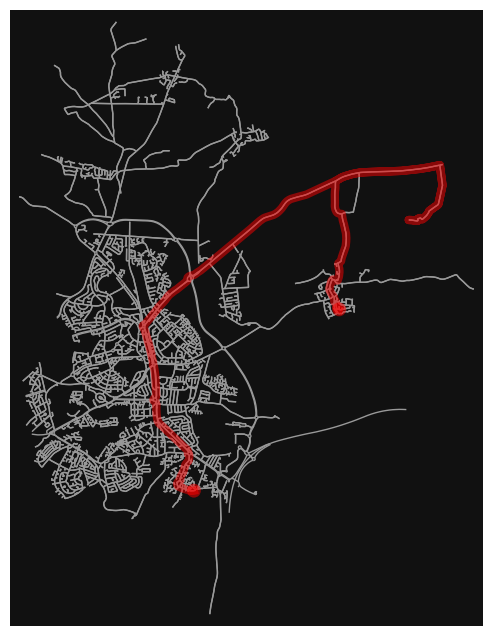

20999.118000000002

In [342]:
print(paths)
print(traversal_path)
osmnx.plot_graph_route(seed_graphs[3], traversal_path, route_color='r', node_size = 0, route_linewidth=6)
sum(path_lengths)

In [343]:
print(len(traversal_path))
print(len(set(traversal_path)))

#remove duplicate nodes but keep the first occurence
remove_indices = [i for i, path in enumerate(traversal_path) if path in traversal_path[:i]]
for i in range(len(remove_indices)):
    remove_indices.insert(0,remove_indices[0]-1)
print(remove_indices)

removed_path = [node for i, node in enumerate(traversal_path) if i in remove_indices]
traversal_path_copy = [node for i, node in enumerate(traversal_path) if i not in remove_indices]
print(traversal_path)
print(traversal_path_copy)

96
94
[76, 77, 78, 79]
[6201798905, 9442235480, 1111898625, 2007045020, 250164006, 2007045031, 250164005, 250164004, 250164002, 1042152986, 250164000, 250163999, 250163998, 2014547586, 250163964, 31942924, 31942951, 1296980314, 2007045681, 2007045753, 31943030, 31943100, 31943208, 3466881, 32045797, 3466858, 30831487, 1056671904, 3466839, 1056671899, 940209726, 940209949, 4470682780, 442515910, 250751957, 7325229512, 250755467, 3467321, 5191656447, 3467311, 26662916, 4474326837, 7869213704, 26662910, 3396095147, 938315699, 4492523199, 3467912, 10439707, 10439711, 3467921, 6854093016, 30822567, 8272450257, 358210626, 6403062632, 7934788508, 21099384, 940194855, 36150229, 5362356803, 6181927034, 6181929893, 6181929896, 6181929890, 6181927030, 9975611349, 6549748439, 8511872733, 6549748441, 6549748417, 6549748421, 8994370272, 1614031238, 1275815184, 1614047775, 1614031202, 432468718, 1614031202, 1614047775, 1614047755, 88889919, 964867171, 1614047628, 267012679, 267012684, 267012689, 1619

In [344]:
# distance = []
# for node in removed_double_path:
#     distance.append(leeds_city_graph.get_edge_data(traversal_path[traversal_path.index(node)], traversal_path[traversal_path.index(node)+1])[0]['length'])
# sum(distance)

In [345]:
# subgraph_3 == 2007045753
start_node = traversal_path[0]
start_node

6201798905

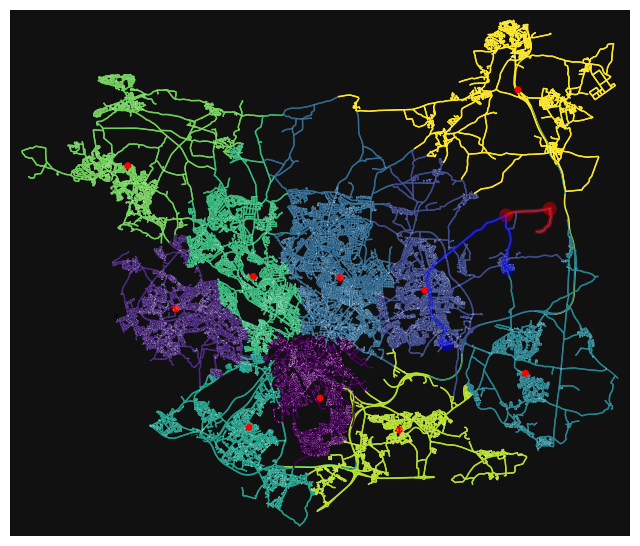

In [346]:
# Plot the Voronoi diagram with 10 seed points and 10 cells (one for each seed point)
fig, ax = osmnx.plot_graph(leeds_city_graph, node_color=node_colours, edge_color=edge_colours, node_size=node_size, node_zorder=2, show=False, close=False)
osmnx.plot.plot_graph_route(leeds_city_graph, traversal_path_copy, route_color='b', route_linewidth=3, node_size=0, route_alpha=0.4, bgcolor='k', ax=ax, show=False, close=False)
osmnx.plot.plot_graph_route(leeds_city_graph, removed_path, route_color='r', route_linewidth=3, node_size=0, route_alpha=0.4, bgcolor='k', ax=ax)
plt.show()

In [347]:
osmnx.folium.plot_route_folium(leeds_city_graph, removed_path, route_color='r', node_size = 0, route_linewidth=6)

In [348]:
print(len(traversal_path))
print(len(set(traversal_path)))

96
94
